In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
import pandas
import sklearn
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,Conv2DTranspose,Concatenate,UpSampling2D,Add,Input,Reshape
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import plot_model
from keras.src.layers.normalization.batch_normalization_v1 import BatchNormalization

In [3]:
class EncoderBlock(Layer):

    def __init__(self, filters, kernel, pooling, **kwargs):
        super(EncoderBlock,self).__init__(**kwargs)

        self.filters=filters
        self.kernel=kernel
        self.pooling=pooling

        self.conv1=Conv2D(self.filters,self.kernel,activation="relu")
        self.conv2=Conv2D(self.filters,self.kernel,activation="relu")
        self.max1=MaxPooling2D(self.pooling)
        self.my_variable = self.add_weight(
            name="my_variable",
            shape=(1,),
            initializer="zeros",
            trainable=True,
        )

    def call(self,inputs):

        x=self.conv1(inputs)
        x=self.conv2(x)
        y=self.max1(x)
        return (y,x)

In [4]:
class DecoderBlock(Layer):

    def __init__(self, filters,kernel,stride, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.filters=filters
        self.kernel=kernel
        self.stride=stride
        self.conv2 = Conv2D(32, (1, 1), padding='same')

        self.batchn=BatchNormalization()
        self.conv2T=Conv2DTranspose(self.filters,self.kernel,strides=self.stride,activation="relu")
        self.my_variable = self.add_weight(
            name="my_variable",
            shape=(1,),
            initializer="zeros",
            trainable=True,
        )

    def call(self,X):

        y,y_skip=X

        x=self.batchn(y)
        x=self.conv2T(x)
        y_skip=tf.image.resize(y_skip, tf.shape(x)[1:3])
        x=Concatenate(axis=-1)([x,y_skip])

        return x


In [5]:
class UNetGate(Layer):

    def __init__(self, filters,kernel,stride, **kwargs):
        super(UNetGate, self).__init__(**kwargs)

        self.filters=filters
        self.kernel=kernel
        self.stride=stride
        self.conv1=Conv2D(self.filters,self.kernel,self.stride,activation="relu")
        self.upsample=UpSampling2D()
        self.down=Conv2D(self.filters,self.kernel,activation="relu")
        self.my_variable = self.add_weight(
            name="my_variable",
            shape=(1,),
            initializer="zeros",
            trainable=True,
        )


    def call(self,X):

        y,y_skip=X

        x=self.conv1(y)
        y_skip=self.down(y_skip)
        y_skip=tf.image.resize(y_skip, tf.shape(x)[1:3])

        x=Concatenate(axis=-1)([x,y_skip])

        x=self.upsample(x)

        return x


In [6]:
np=Input((256,256,3))

x1,xs1=EncoderBlock(filters=32, kernel=(3,3), pooling=(3,3))(np)

x2,xs2=EncoderBlock(filters=32, kernel=(3,3), pooling=(3,3))(x1)
x3,xs3=EncoderBlock(filters=32, kernel=(3,3), pooling=(3,3))(x2)

y1=DecoderBlock(filters=32,kernel=(3,3),stride=2)([x3,xs3])
u1=UNetGate( filters=1,kernel=(2,2),stride=3)([y1,xs3])

y2=DecoderBlock(filters=32,kernel=(3,3),stride=2)([u1,xs2])
u2=UNetGate( filters=1,kernel=(2,2),stride=1)([y2,xs2])

y3=DecoderBlock(filters=32,kernel=(3,3),stride=1)([u2,xs1])
u3=UNetGate( filters=1,kernel=(2,2),stride=1)([y3,xs1])

flat=Flatten()(u3)
dense1=Dense(64*64*1,activation="relu")(flat)
dense2=Dense(256*256*1,activation="relu")(dense1)

resh=Reshape((256,256,1))(dense2)

output=Conv2D(filters=1,kernel_size=(1,1),activation="sigmoid")(resh)


In [7]:
model=tf.keras.models.Model(inputs=[np],outputs=[output])

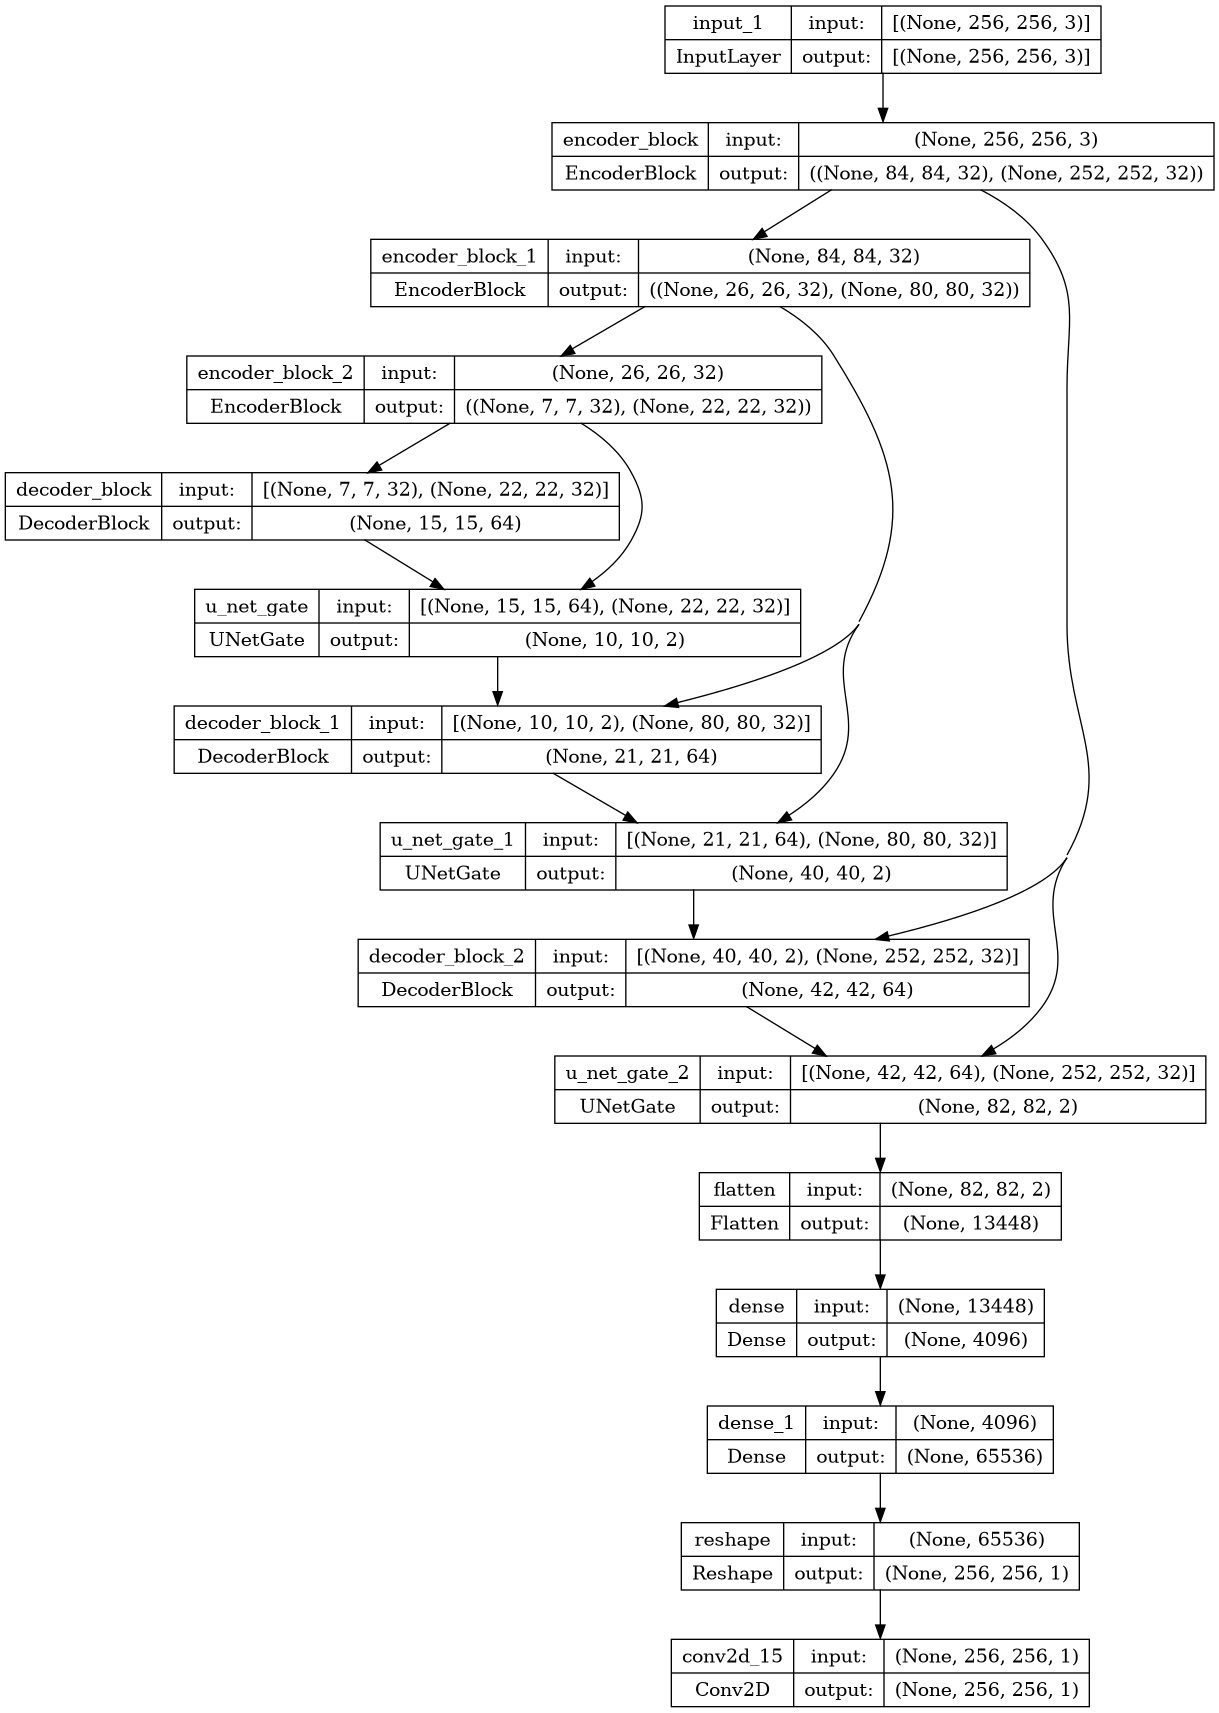

In [8]:
plot_model(model,show_layer_names=True,show_shapes=True)

In [9]:
import numpy
k=[[[0,0,0] for i in range(256)]for j in range(256)]

In [10]:
numpy.shape(k)

(256, 256, 3)

In [11]:
z=[[[0] for i in range(256)]for j in range(256)]

In [12]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics="mae")

In [13]:
model.fit([k],[z],epo)

1/1 [==============================] - 10s 10s/step - loss: 0.6931 - mae: 0.5000
